# Text Summarization using Transformers

This notebook implements T-5 transformer on news_summary_more dataset to generate news summary.

## Install all the reuqired Libraries

In [ ]:

!pip install transformers -q
!pip install wandb -q
!pip install sentencepiece
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing  libraries

In [ ]:

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from rouge import Rouge
from transformers import T5Tokenizer, T5ForConditionalGeneration
import wandb

## Setting up wandb to store the weights after trainig our model

In [ ]:
from torch import cuda
import os
device = 'cuda' if cuda.is_available() else 'cpu'
os.environ["WANDB_NOTEBOOK_NAME"] = "dl_final_proj.ipynb"
!wandb login

wandb: Currently logged in as: harsh-c2699 (dl_proj). Use `wandb login --relogin` to force relogin


In [ ]:
rouge=Rouge()

## Implementing a class to preprocess the dataset

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, source_len, summ_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.summ_len = summ_len
        self.text = self.data.text
        self.headlines = self.data.headlines

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        headlines = str(self.headlines[index])
        headlines = ' '.join(headlines.split())

        text = str(self.text[index])
        text = ' '.join(text.split())

        target = self.tokenizer.batch_encode_plus([headlines], max_length= self.source_len, pad_to_max_length=True,return_tensors='pt')
        source = self.tokenizer.batch_encode_plus([text], max_length= self.summ_len, pad_to_max_length=True,return_tensors='pt')

        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids': source_ids.to(dtype=torch.long), 
            'source_mask': source_mask.to(dtype=torch.long), 
            'target_ids': target_ids.to(dtype=torch.long),
            'target_ids_y': target_ids.to(dtype=torch.long)
        }

## Defining the training unction

In [ ]:
def train(epoch, tokenizer, model, device, loader, optimizer):
    model.train()
    print("For Epoch",epoch)
    for _,data in enumerate(loader, 0):
        y = data['target_ids'].to(device, dtype = torch.long)
        y_ids = y[:, :-1].contiguous()
        labels = y[:, 1:].clone().detach()
        labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data['source_ids'].to(device, dtype = torch.long)
        mask = data['source_mask'].to(device, dtype = torch.long)

        outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=labels)
        

        loss = outputs[0]
        
        if _%10 == 0:
            wandb.log({"Training Loss": loss.item()})

        if _%500==0:
            print(f'Step: {_}, Loss:  {loss.item()}')
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

## Defining the testing function

In [ ]:
def testing(epoch, tokenizer, model, device, loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = ids,
                attention_mask = mask, 
                max_length=150, 
                num_beams=2,
                repetition_penalty=2.5, 
                length_penalty=1.0, 
                early_stopping=True
                )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
            if _%100==0:
                print(f'Completed {_}')

            predictions.extend(preds)
            actuals.extend(target)
    return predictions, actuals

## Setting the history dictionary for the Rouge scores

In [ ]:
history_rouge1 = {'r': [], 'p': [] ,'f':[]}
history_rouge2 = {'r': [], 'p': [] ,'f':[]}
history_rougeL = {'r': [], 'p': [] ,'f':[]}

## Defining the main function to preprocess, train and test the dataset

In [ ]:
def main():

    wandb.init(project="dl_final_proj")

    # defining config variables in wandb which will be used as hyperparameters in training
    config = wandb.config         
    config.TRAIN_BATCH_SIZE = 2    
    config.TEST_BATCH_SIZE = 2   
    config.TRAIN_EPOCHS = 2        
    config.TEST_EPOCHS = 1 
    config.LEARNING_RATE = 1e-4    
    config.SEED = 42             
    config.MAX_LEN = 512
    config.SUMMARY_LEN = 150 

    torch.manual_seed(config.SEED)
    np.random.seed(config.SEED) 
    torch.backends.cudnn.deterministic = True

    # tokenzier for encoding the text
    tokenizer = T5Tokenizer.from_pretrained("t5-base")
    
    df = pd.read_csv('/content/news_summary_more.csv',encoding='latin-1')
    df = df[['text','headlines']]
    df.text = 'summarize: ' + df.text
    print(df.head())
 
    train_size = 0.8
    train_dataset=df.sample(frac=train_size,random_state = config.SEED)
    test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
    train_dataset = train_dataset.reset_index(drop=True)

    print("FULL Dataset: {}".format(df.shape))
    print("TRAIN Dataset: {}".format(train_dataset.shape))
    print("TEST Dataset: {}".format(test_dataset.shape))


    # Creating the Training and Validation dataset for further creation of Dataloader
    training_set = CustomDataset(train_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)
    val_set = CustomDataset(test_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)

    # Defining the parameters for creation of dataloaders
    train_params = {
        'batch_size': config.TRAIN_BATCH_SIZE,
        'shuffle': True,
        'num_workers': 0
        }

    test_params = {
        'batch_size': config.TEST_BATCH_SIZE,
        'shuffle': False,
        'num_workers': 0
        }

    # Creation of Dataloaders for testing and testing. This will be used down for training and testing stage for the model.
    training_loader = DataLoader(training_set, **train_params)
    test_loader = DataLoader(val_set, **test_params)


    
    # Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary. 
   
    model = T5ForConditionalGeneration.from_pretrained("t5-base")
    model = model.to(device)

    # Defining the optimizer that will be used to tune the weights of the network in the training session. 
    optimizer = torch.optim.Adam(params =  model.parameters(), lr=config.LEARNING_RATE)

    # Log metrics with wandb
    wandb.watch(model, log="all")
    # Training loop
    print('Initiating Fine-Tuning for the model on our dataset')

    for epoch in range(config.TRAIN_EPOCHS):
        train(epoch, tokenizer, model, device, training_loader, optimizer)


    # Testing loop and saving the resulting file with predictions and acutals in a dataframe.
    # Saving the dataframe as predictions.csv
    print('Now generating summaries on our fine tuned model for the testing dataset and saving it in a dataframe')
    for epoch in range(config.TEST_EPOCHS):
        predictions, actuals = testing(epoch, tokenizer, model, device, test_loader)
        for i in range(len(predictions)):
          scores = rouge.get_scores(predictions[i],actuals[i])
          history_rouge1['r'].append(scores[0]['rouge-1']['r'])
          history_rouge1['p'].append(scores[0]['rouge-1']['p'])
          history_rouge1['f'].append(scores[0]['rouge-1']['f'])
          history_rouge2['r'].append(scores[0]['rouge-2']['r'])
          history_rouge2['p'].append(scores[0]['rouge-2']['p'])
          history_rouge2['f'].append(scores[0]['rouge-2']['f'])
          history_rougeL['r'].append(scores[0]['rouge-l']['r'])
          history_rougeL['p'].append(scores[0]['rouge-l']['p'])
          history_rougeL['f'].append(scores[0]['rouge-l']['f'])
        final_df = pd.DataFrame({'Generated Text':predictions,'Actual Text':actuals})
        final_df.to_csv('/content/predictions.csv')
        print('Output Files generated for review')

if __name__ == '__main__':
    main()

Training Loss,██▄▅▂▆▃█▃▅▃▇▂▂▄▃▄▅▄▅▄▇▄▄▃▄▃▃▃▅▅▄▃▂▃▁▃▄▁▆
Training Loss,2.69737


/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


                                                text  \
0  summarize: Saurav Kant, an alumnus of upGrad a...   
1  summarize: Kunal Shah's credit card bill payme...   
2  summarize: New Zealand defeated India by 8 wic...   
3  summarize: With Aegon Life iTerm Insurance pla...   
4  summarize: Speaking about the sexual harassmen...   

                                           headlines  
0  upGrad learner switches to career in ML & Al w...  
1  Delhi techie wins free food from Swiggy for on...  
2  New Zealand end Rohit Sharma-led India's 12-ma...  
3  Aegon life iTerm insurance plan helps customer...  
4  Have known Hirani for yrs, what if MeToo claim...  
FULL Dataset: (98401, 2)
TRAIN Dataset: (78721, 2)
TEST Dataset: (19680, 2)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Initiating Fine-Tuning for the model on our dataset
For Epoch 0
Step: 0, Loss:  8.736738204956055


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Step: 500, Loss:  2.070082902908325
Step: 1000, Loss:  2.2153677940368652
Step: 1500, Loss:  1.3904058933258057
Step: 2000, Loss:  1.1587929725646973
Step: 2500, Loss:  2.026728868484497
Step: 3000, Loss:  1.5091441869735718
Step: 3500, Loss:  1.3414908647537231
Step: 4000, Loss:  1.510045051574707
Step: 4500, Loss:  1.6984916925430298
Step: 5000, Loss:  1.7449537515640259
Step: 5500, Loss:  2.0123379230499268
Step: 6000, Loss:  1.2901524305343628
Step: 6500, Loss:  2.1049060821533203
Step: 7000, Loss:  1.5381247997283936
Step: 7500, Loss:  1.4996236562728882
Step: 8000, Loss:  0.9163416624069214
Step: 8500, Loss:  1.2738027572631836
Step: 9000, Loss:  0.8966700434684753
Step: 9500, Loss:  1.6289087533950806
Step: 10000, Loss:  1.4995611906051636
Step: 10500, Loss:  1.3650879859924316
Step: 11000, Loss:  1.2765742540359497
Step: 11500, Loss:  2.37483286857605
Step: 12000, Loss:  2.269894599914551
Step: 12500, Loss:  0.993208110332489
Step: 13000, Loss:  0.8614000082015991
Step: 13500, 

In [ ]:
# import math
# import numpy as np
# np.mean(history_rouge1['f'])
len(history_rouge1['r'])

19680

## Plotting the recall rouge scores for generated summaries

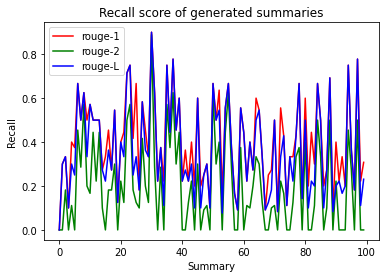

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
  
# Using Numpy to create an array X
X = np.arange(0,len(history_rouge1['r'][0:100]))
y = history_rouge1['r'][0:100]
z = history_rouge2['r'][0:100]
zz= history_rougeL['r'] [0:100]
plt.plot(X, y, color='r', label='rouge-1')
plt.plot(X, z, color='g', label='rouge-2')
plt.plot(X, zz, color='b', label='rouge-L')
plt.xlabel("Summary")
plt.ylabel("Recall")
plt.title("Recall score of generated summaries")
plt.legend()
plt.show()

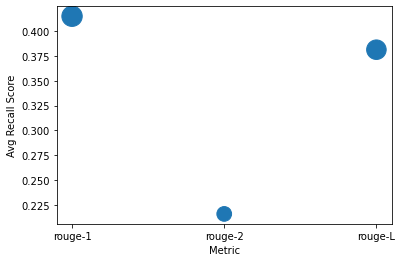

In [ ]:
y=[np.mean(history_rouge1['r']),np.mean(history_rouge2['r']),np.mean(history_rougeL['r'])]
x=['rouge-1','rouge-2','rouge-L']
s=[1000*n for n in y]
plt.scatter(x,y,s)
plt.xlabel("Metric")
plt.ylabel("Avg Recall Score")
plt.show()

## Plotting the precision rouge scores for generated summaries

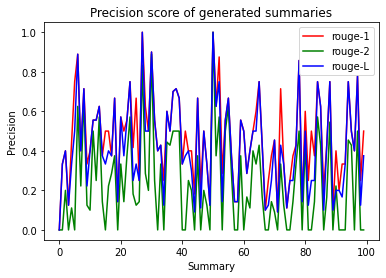

In [ ]:

X = np.arange(0,len(history_rouge1['p'][0:100]))
y = history_rouge1['p'][0:100]
z = history_rouge2['p'][0:100]
zz= history_rougeL['p'][0:100]
plt.plot(X, y, color='r', label='rouge-1')
plt.plot(X, z, color='g', label='rouge-2')
plt.plot(X, zz, color='b', label='rouge-L')
plt.xlabel("Summary")
plt.ylabel("Precision")
plt.title("Precision score of generated summaries")
plt.legend()
plt.show()

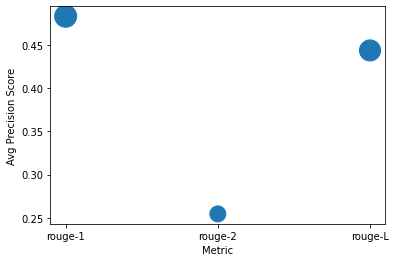

In [ ]:
y=[np.mean(history_rouge1['p']),np.mean(history_rouge2['p']),np.mean(history_rougeL['p'])]
x=['rouge-1','rouge-2','rouge-L']
s=[1000*n for n in y]
plt.scatter(x,y,s)
plt.xlabel("Metric")
plt.ylabel("Avg Precision Score")
plt.show()

## Plotting the F rouge scores for generated summaries

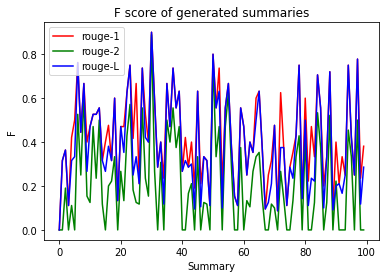

In [ ]:
X = np.arange(0,len(history_rouge1['f'][0:100]))
y = history_rouge1['f'][0:100]
z = history_rouge2['f'][0:100]
zz= history_rougeL['f'][0:100]
plt.plot(X, y, color='r', label='rouge-1')
plt.plot(X, z, color='g', label='rouge-2')
plt.plot(X, zz, color='b', label='rouge-L')
plt.xlabel("Summary")
plt.ylabel("F")
plt.title("F score of generated summaries")
plt.legend()
plt.show()

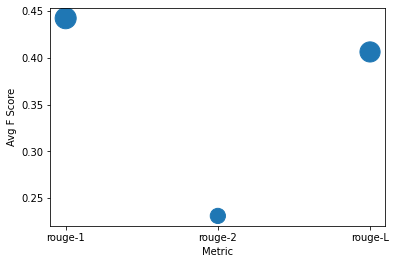

In [ ]:
y=[np.mean(history_rouge1['f']),np.mean(history_rouge2['f']),np.mean(history_rougeL['f'])]
x=['rouge-1','rouge-2','rouge-L']
s=[1000*n for n in y]
plt.scatter(x,y,s)
plt.xlabel("Metric")
plt.ylabel("Avg F Score")
plt.show()